In [45]:

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
import statsmodels.stats as stats
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline
pd.set_option('display.max_columns', None)

## Load data
1. All 3 tables are merged
2. Tables are filtere to only include sales in 2019 of homes between 120,000 and 3,000,000 dollars
3. Merged table is divided into 2 tables: ordtable = ordinal features, cattable = categorical features.

We chose to separate the tables to make modeling easier, and make clear what needs to be one-hotted before adding to the model.

In [46]:
data_dict = data_download.get_dataframes()

KeyboardInterrupt: 

In [ ]:
data_dict['rp_sale'] = data_dict['rp_sale'][(data_dict['rp_sale']['SalePrice'] > 200000) & (data_dict['rp_sale']['SalePrice'] < 1500000)]

ordtable, cattable = data_download.get_tables(data_dict)

In [ ]:
for x in cattable.columns:
    cattable[x] = cattable[x].astype('category')

In [60]:
cattable

,SaleReason,PropertyClass,HeatSystem,HeatSource,PresentUse,HBUAsIfVacant,HBUAsImproved,WaterSystem,SewerSystem,Access,InadequateParking,StreetSurface,Topography,WfntLocation,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,PowerLines,OtherNuisances,AdjacentGolfFairway,AdjacentGreenbelt
0,1,8,4,3,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
1,1,8,5,2,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
2,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
3,1,8,1,2,29,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
4,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,1,8,5,2,2,1,1,2,1,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
26102,1,8,5,1,2,1,1,2,2,4,0,1,0,0,0,0,0,N,N,0,N,N,N,N
26103,1,8,6,1,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N
26104,1,8,5,2,2,1,1,2,2,4,2,1,0,0,0,0,0,N,N,0,N,N,N,N


## Let RFECV choose my features for me

After a lot of experimentation, I chose 17 features.  More than that increase my condition score to unacceptable levels, and less than that reduced the R<sup>2</sup> score.

## Feed the selected predictors into the regression model

In [85]:
predictors = ordtable.drop(columns = ['SalePrice']).copy()
y = ordtable.SalePrice.copy()
y = y.reset_index(drop=True)

#predictors['BldgGrade'] = predictors['BldgGrade'].astype('category')
predictors['PropertyClass'] = cattable['PropertyClass']
predictors['InadequateParking'] = cattable['InadequateParking']
predictors['SaleReason'] = cattable['SaleReason']
#predictors['YrBuilt'] = predictors['YrBuilt'].astype('category')
predictors['WfntLocation'] = cattable['WfntLocation']
predictors['AdjacentGreenbelt'] = cattable['AdjacentGreenbelt']
predictors['PresentUse'] = cattable['PresentUse']
#predictors['SewerSystem'] = cattable['SewerSystem']
predictors['AdjacentGolfFairway'] = cattable['AdjacentGolfFairway']

predictors['TidelandShoreland'] = cattable['TidelandShoreland']
predictors['WfntAccessRights'] = cattable['WfntAccessRights']

#predictors['Condition'] = predictors['Condition'].astype('category')

predictors = pd.get_dummies(predictors, drop_first = True)

todrop =    [
            'SqFtLot',
             #'SqFtTotLiving',
             'SqFt1stFloor',
             'PropertyClass_7',
             'PropertyClass_8',
             'SqFtTotBasement',
             'SqFtFinBasement'
            ]
predictors = predictors.drop(columns = todrop)
standardords = predictors



pt = preprocessing.StandardScaler()
standardords = pd.DataFrame(pt.fit_transform(predictors))
standardords.columns = predictors.columns


lr = LinearRegression(normalize = False)
select = RFECV(lr)
select = select.fit(X = standardords, y = y)

selected_scales = pt.scale_[select.support_]
selected_scales = np.insert(selected_scales,0,1) #add one for the intercept

X = standardords[standardords.columns[list(select.support_)]].reset_index(drop=True)

results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     896.8
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:55:42   Log-Likelihood:            -3.5171e+05
No. Observations:               25780   AIC:                         7.035e+05
Df Residuals:                   25754   BIC:                         7.037e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.84e+05   1268.527    539.191      0.000    6.81e+05    6.86e+05
Stories              3.888e+04   1783.728     21.798      0.000    3.54e+04    4.24e+04
BldgGrade            1.317e+05   1990.315     66.175      0.000    1.28e+05    1.36e+05
SqFtTotLiving         8.36e+04   2529.928     33.046      0.000    7.86e+04    8.86e+04
SqFtGarageBasement  -9303.0488   1559.256     -5.966      0.000   -1.24e+04   -6246.820
FinBasementGrade     1.499e+04   1685.231      8.898      0.000    1.17e+04    1.83e+04
SqFtGarageAttached  -3.371e+04   1929.742    -17.467      0.000   -3.75e+04   -2.99e+04
SqFtOpenPorch        9747.0399   1426.706      6.832      0.000    6950.615    1.25e+04
Bedrooms            -2.712e+04   1761.633    -15.392      0.000   -3.06e+04   -2.37e+04
Bath3qtrCount        2.541e+04   1713.057     14.833      0.000    2.21e+04    2.88e+04
BathFullCount        2.285e+04   2077.065     10.999      0.000    1.88e+04    2.69e+04
YrBuilt             -8.276e+04   1873.281    -44.181      0.000   -8.64e+04   -7.91e+04
AddnlCost           -1.364e+04   1314.458    -10.380      0.000   -1.62e+04   -1.11e+04
Olympics             9727.2065   1319.273      7.373      0.000    7141.357    1.23e+04
SeattleSkyline       1.009e+04   1289.690      7.821      0.000    7558.369    1.26e+04
LakeWashington       9707.7437   1300.765      7.463      0.000    7158.172    1.23e+04
LakeSammamish        1.033e+04   1273.660      8.109      0.000    7831.814    1.28e+04
InadequateParking_2  7433.1837   1281.340      5.801      0.000    4921.685    9944.682
SaleReason_4         -1.04e+04   1270.815     -8.186      0.000   -1.29e+04   -7911.796
SaleReason_8        -7008.2703   1271.769     -5.511      0.000   -9501.009   -4515.531
SaleReason_12       -8993.2370   1269.216     -7.086      0.000   -1.15e+04   -6505.503
SaleReason_18       -1.722e+04   1275.624    -13.503      0.000   -1.97e+04   -1.47e+04
SaleReason_19       -7578.4083   1269.918     -5.968      0.000   -1.01e+04   -5089.298
AdjacentGreenbelt_Y  1.288e+04   1292.093      9.970      0.000    1.03e+04    1.54e+04
PresentUse_300      -8180.7622   1290.771     -6.338      0.000   -1.07e+04   -5650.778
TidelandShoreland_2  7582.0015   1309.428      5.790      0.000    5015.450    1.01e+04
==============================================================================
Omnibus:                     1659.545   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2776.198
Skew:                           0.507   Prob(JB):                         0.00
Kurtosis:                       4.248   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance

In [86]:
coefficients = results.params / selected_scales
coefficients

const                  683977.680140
Stories                 71572.544250
BldgGrade              129758.759700
SqFtTotLiving             100.360837
SqFtGarageBasement        -52.510359
FinBasementGrade         4251.712889
SqFtGarageAttached       -121.649170
SqFtOpenPorch              87.262279
Bedrooms               -29373.150995
Bath3qtrCount           40491.857833
BathFullCount           33661.705434
YrBuilt                 -2620.555566
AddnlCost                  -6.532326
Olympics                30740.148593
SeattleSkyline          58231.438473
LakeWashington          38162.909700
LakeSammamish           91959.414839
InadequateParking_2     15384.137363
SaleReason_4          -183631.539751
SaleReason_8           -88417.009351
SaleReason_12         -278037.359022
SaleReason_18          -86670.727199
SaleReason_19         -430270.783455
AdjacentGreenbelt_Y     79424.110804
PresentUse_300         -82505.391334
TidelandShoreland_2    138049.875449
dtype: float64

### Assumption Testing

### Homoskedasticity:
Our Durbin-Watson score is 1.911, which is within the range of values that show our residuals are homoskedastic.  Further, the below chart also shows a mostly even distribution of errors around 0.  However, we do see that our errors are a little greater at lower prices homes, but this is probably because our data is skewed toward the lower prices.

The below chart also shows a mostly even distribution of errors around 0.  However, we do see that our errors are a little greater at lower prices homes, but this is probably because our data is skewed toward the lower prices.

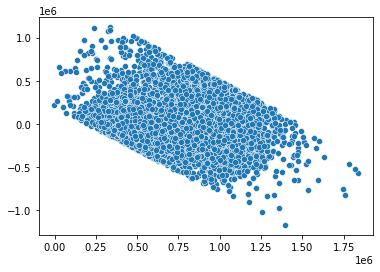

In [87]:
y_hat = results.predict()
sns.scatterplot(x = y_hat, y = results.resid)

### Linearity

We pass the linear rainbow test for linearity with flying colors by soundly rejecting the null hypothesis of non-linearity. 

#### Linear Rainbow Test:

In [88]:
rainbow_statistic, rainbow_p_value = linear_rainbow(results)
print( f'rainbow Statistic: {rainbow_statistic}')
print(f'rainbow pvalue: {rainbow_p_value}')


rainbow Statistic: 0.9518164638038433
rainbow pvalue: 0.9974586735488045


### Normality
Our model violates the normality assumption.
The Jarque-Bera score in the above model summary fails to reject the null hypothesis that our residuals are not normally distributed.  This non-normalitity is clearly visible in the below QQtest. 

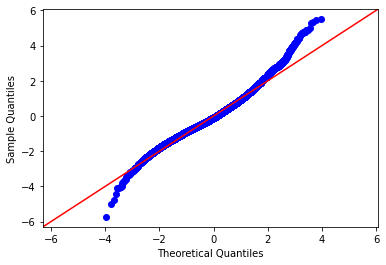

In [89]:
fig = sm.graphics.qqplot(results.resid, dist = scipy.stats.norm, line = '45', fit=True)

### Independence (collinearity)
Our model does not violate the indepedence assumption.
Our above condition score is low, suggesting low multi-collinearity between features. The below variance inflaction test shows that no feature scores above a 5.  This confirms that our features are independent.

In [90]:
rows = X.values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(X.columns))]
vif_df["feature"] = X.columns

vif_df

,VIF,feature
0,1.977233,Stories
1,2.461753,BldgGrade
2,3.977562,SqFtTotLiving
3,1.510899,SqFtGarageBasement
4,1.764898,FinBasementGrade
5,2.314192,SqFtGarageAttached
6,1.264940,SqFtOpenPorch
7,1.928552,Bedrooms
8,1.823661,Bath3qtrCount
9,2.681025,BathFullCount
